### 1. Imports

In [1]:
!pip install torchgeo --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 13.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 55.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 36.4 MB/s eta 0:00:00


In [2]:
import os
import torch
import rasterio
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from rasterio.warp import reproject, Resampling
from collections import defaultdict
import torch.nn as nn
from torch.optim import AdamW  
from torch.optim.lr_scheduler import ReduceLROnPlateau  
from torch.utils.data import Dataset, Subset, DataLoader, WeightedRandomSampler
from torchvision import transforms  
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torchgeo.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### 2. Utility functions

In [3]:
# Set seeds once
seed = 42
pl.seed_everything(seed, workers=True)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Seed set to 42


In [4]:
class S2Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, bands, class_idx=None, labeled=True, transform=None, target_size=264):
        self.root_dir = root_dir
        self.bands = bands
        self.labeled = labeled
        self.transform = transform
        self.class_idx = class_idx if class_idx is not None else {}
        self.samples = []
        self.target_size = target_size

        # all samples
        if labeled:
            for cls_name, label in self.class_idx.items():
                cls_dir = os.path.join(root_dir, cls_name)
                if not os.path.exists(cls_dir):
                    continue
                for img_id in sorted(os.listdir(cls_dir)):
                    img_dir = os.path.join(cls_dir, img_id)
                    if os.path.isdir(img_dir):
                        self.samples.append((img_dir, label))
        else:
            for img_id in sorted(os.listdir(root_dir)):
                img_dir = os.path.join(root_dir, img_id)
                if os.path.isdir(img_dir):
                    self.samples.append((img_dir, None))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_dir, label = self.samples[idx]
        bands_data = []
        H = W = self.target_size
        for band in self.bands:
            band_path = os.path.join(img_dir, f"{band}.tif")
            if os.path.exists(band_path):
                with rasterio.open(band_path) as src:
                    arr = src.read(1, out_shape=(H, W), 
                                   resampling=Resampling.bilinear).astype(np.float32)
            else:
                arr = np.zeros((H, W), dtype=np.float32)
            bands_data.append(torch.from_numpy(arr))

        # B10 as zeros
        if "B10" not in self.bands:
            bands_data.insert(10, torch.zeros((H, W), dtype=torch.float32))

        img = torch.stack(bands_data, dim=0)
        if self.transform:
            img = self.transform(img)
        if self.labeled:
            return img, label
        else:
            img_id = os.path.basename(img_dir)  
            return img, img_id

In [5]:
# MEAN AND STD FROM DATA
def calculate_stats(dataset):
    # Stack all images into a single tensor of shape (N, 13, H, W)
    all_images = torch.stack([img for img, _ in dataset])
    # Compute mean and std per band (across N, H, W)
    mean = all_images.mean(dim=(0, 2, 3)) # Shape: (13,)
    std = all_images.std(dim=(0, 2, 3)) # Shape: (13,)
    return mean, std

# SPLIT DATA
def stratified_split(dataset, val_ratio=0.2, seed=42):
    random.seed(seed)
    class_indices = defaultdict(list)
    for i, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(i)
    train_idx, val_idx = [], []
    for label, indices in class_indices.items():
        random.shuffle(indices)
        n_val = max(1, int(len(indices) * val_ratio))
        val_idx.extend(indices[:n_val])
        train_idx.extend(indices[n_val:])
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

Prep data for model

In [6]:
# root directory
input_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle'

# bands in order
bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"] #missing B10

# classes
class_idx = {"Aphid": 0, "Blast": 1, "RPH": 2, "Rust": 3}

In [7]:
# load dataset
dataset = S2Dataset(root_dir=input_path, bands=bands, class_idx=class_idx, labeled=True, transform=None)

# sanity check
print(dataset.__len__())
img, label = dataset.__getitem__(0)
print(f"Shape: {img.shape}, Label: {label}")

900
Shape: torch.Size([13, 264, 264]), Label: 0


In [8]:
# mean, std = calculate_stats(dataset)
# print(mean, std)

In [9]:
mean = [2358.7412, 2402.7629, 2580.9255, 2614.2227, 3057.6877, 3578.1008,
        3796.8345, 3795.6868, 3947.5913, 4833.6362,    0.0000, 3379.1743,
        2666.4465]
std = [2994.4861, 2847.0354, 2542.9307, 2411.1196, 2399.0249, 2137.6804,
        2036.8357, 2042.7140, 1957.9615, 3559.4121,    0.0000, 1535.7960,
        1393.8278]

# to avoid 0 std
std = [max(s, 1e-5) for s in std]   

# define transform
# Training transforms 
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])


In [10]:
# split data
train_dataset, val_dataset = stratified_split(dataset, val_ratio=0.2)

# apply transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [11]:
# Weighted sampler + loss weights 
def weighted_sampler(dataset_subset, num_classes):
    """
    Creates WeightedRandomSampler based on class frequencies in the subset.    
    Args:
        dataset_subset: Subset or Dataset with .samples attribute
        num_classes: int 
    Returns:
        WeightedRandomSampler ready for DataLoader
    """
    # Get labels from the subset
    labels = [dataset_subset.dataset.samples[i][1] for i in dataset_subset.indices]
    labels_tensor = torch.tensor(labels)   
    # Count occurrences per class
    class_counts = torch.bincount(labels_tensor, minlength=num_classes).float()
    print("Class counts in train split:", class_counts.tolist()) 
    # Inverse frequency weights
    weights = 1.0 / (class_counts + 1e-8)           # avoid division by zero
    weights = weights / weights.sum()                # normalize
    # Assign weight to each sample
    sample_weights = [weights[label].item() for label in labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

In [12]:
# Create sampler for train
num_classes = len(class_idx)
train_sampler = weighted_sampler(train_dataset, num_classes=num_classes)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=False,num_workers=4,pin_memory=True)

# Loss weights (for Focal loss) 
labels = torch.tensor([label for _, label in dataset.samples]) #collect all labels
class_counts = torch.bincount(labels, minlength=num_classes).float() #num of images per class
class_counts_for_loss = class_counts  
alpha = 1.0 / (class_counts_for_loss + 1e-8) #compute raw inverse frequency, used 1e-8 to avoid division by 0
alpha = alpha / alpha.sum() * num_classes   # normalize so average ~1
print("Loss/Focal alpha weights:", alpha.tolist())

Class counts in train split: [232.0, 60.0, 396.0, 32.0]
Loss/Focal alpha weights: [0.31489798426628113, 1.2176055908203125, 0.18448570370674133, 2.283010482788086]


### 3. MoCo model with resnet50 backbone

In [13]:
# Helper: Load MoCo-pretrained encoder (TorchGeo or custom)
def load_moco_encoder(
    checkpoint_path=None,              
    architecture="resnet50",
    verbose=True
):
    if architecture != "resnet50":
        raise NotImplementedError("Only resnet50 supported for now")

    backbone = resnet50(weights=None)

    if checkpoint_path is None:
        if verbose:
            print("Loading official TorchGeo Sentinel-2 MoCo weights")
        backbone = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO)
    else:
        if verbose:
            print(f"Loading custom MoCo checkpoint: {checkpoint_path}")
        state_dict = torch.load(checkpoint_path, map_location="cpu")

        # Clean common prefixes from MoCo checkpoints
        cleaned = {}
        for k, v in state_dict.items():
            new_key = k
            for prefix in ["module.", "encoder_q.", "encoder.", "momentum_encoder.", "backbone."]:
                if new_key.startswith(prefix):
                    new_key = new_key[len(prefix):]
                    break
            cleaned[new_key] = v

        missing, unexpected = backbone.load_state_dict(cleaned, strict=False)
        if verbose:
            print(f"  Missing keys: {len(missing)} | Unexpected: {len(unexpected)}")

    # Remove classification/projection head
    if hasattr(backbone, "fc"):
        backbone.fc = nn.Identity()
    elif hasattr(backbone, "head"):
        backbone.head = nn.Identity()
    else:
        raise ValueError("Cannot find fc/head to replace")

    return backbone

In [14]:
# Downstream Classifier
class MoCoClassifier(pl.LightningModule):
    def __init__(
        self,
        encoder=None,                      # optional: pre-loaded encoder
        custom_checkpoint_path=None,       # alternative: load from path
        num_classes=4,
        lr=3e-3,
        freeze_backbone=True,
        focal_gamma=2.0,
        focal_alpha=None,
        label_smoothing=0.1,
        weight_decay=1e-5,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["encoder", "focal_alpha"])

        # Load or use encoder
        if encoder is not None:
            self.encoder = encoder
            print("Using provided encoder")
        elif custom_checkpoint_path is not None:
            self.encoder = load_moco_encoder(checkpoint_path=custom_checkpoint_path)
        else:
            self.encoder = load_moco_encoder()  # defaults to TorchGeo

        # Feature dimension
        in_features = 2048
        self.classifier = nn.Linear(in_features, num_classes)

        # Freeze backbone for linear probe
        if freeze_backbone:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # Focal loss parameters
        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha
        self.label_smoothing = label_smoothing

        #train 
        self.train_f1_macro = MulticlassF1Score(num_classes=num_classes, average="macro")
        
        # Validation metrics
        self.val_f1_macro = MulticlassF1Score(num_classes=num_classes, average="macro")
        self.val_f1_weighted = MulticlassF1Score(num_classes=num_classes, average="weighted")

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

    def focal_loss(self, logits, targets):
        ce_loss = F.cross_entropy(
            logits,
            targets,
            reduction="none",
            label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.focal_gamma
        loss = focal_weight * ce_loss

        if self.focal_alpha is not None:
            alpha = self.focal_alpha.to(logits.device)
            alpha_t = alpha[targets]
            loss = alpha_t * loss

        return loss.mean()

    def _shared_step(self, batch, stage="train"):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.focal_loss(logits, labels)
    
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
    
        # Log loss and accuracy
        self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    
        # Update and log F1 scores
        if stage == "train":
            self.train_f1_macro.update(preds, labels)
            self.log("train_f1_macro", self.train_f1_macro.compute(), on_step=False, on_epoch=True, prog_bar=True)
            self.train_f1_macro.reset()
        elif stage == "val":
            self.val_f1_macro.update(preds, labels)
            self.val_f1_weighted.update(preds, labels)
            self.log("val_f1_macro", self.val_f1_macro.compute(), on_step=False, on_epoch=True, prog_bar=True)
            self.log("val_f1_weighted", self.val_f1_weighted.compute(), on_step=False, on_epoch=True, prog_bar=True)
    
        return loss


    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_validation_epoch_end(self):
        # Log validation F1 scores
        self.log("val_f1_macro", self.val_f1_macro.compute(), prog_bar=True)
        self.log("val_f1_weighted", self.val_f1_weighted.compute(), prog_bar=True)
        self.val_f1_macro.reset()
        self.val_f1_weighted.reset()

    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        optimizer = AdamW(params, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

        scheduler = ReduceLROnPlateau(
            optimizer,
            mode="max",
            factor=0.5,
            patience=5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1_macro",
                "interval": "epoch",
                "frequency": 1
            }
        }

In [15]:
def train_model(
    model: pl.LightningModule,
    train_loader,
    val_loader,
    max_epochs: int = 60,
    monitor_metric: str = "val_f1_macro",
    mode: str = "max",
    patience: int = 10,
    checkpoint_dir: str = "/kaggle/working/checkpoints/moco_focal"
):

    checkpoint_cb = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename="moco-{epoch:03d}-{val_f1_macro:.4f}",
        monitor=monitor_metric,
        mode=mode,
        save_top_k=1,
        save_last=True,
        verbose=False
    )

    early_stop_cb = EarlyStopping(
        monitor=monitor_metric,
        mode=mode,
        patience=patience,
        min_delta=0.005,
        verbose=True
    )

    lr_monitor_cb = LearningRateMonitor(logging_interval="epoch")

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        logger=CSVLogger(save_dir="/kaggle/working/logs/", 
                         name=f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}", 
                         version=None),
        accelerator="auto",
        devices=1,
        precision="16-mixed",
        callbacks=[checkpoint_cb, early_stop_cb, lr_monitor_cb],
        default_root_dir=checkpoint_dir,
        log_every_n_steps=10,
        enable_progress_bar=True
    )

    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    print(f"\nTotal training time: {(end_time-start_time)/60:.2f} minutes")

    return trainer

In [16]:
# instantiate model
model = MoCoClassifier(
    encoder=None,                      
    custom_checkpoint_path=None,
    num_classes=4,
    lr=1e-3,                   
    freeze_backbone=True,
    focal_gamma=2.0,
    focal_alpha=alpha,          
    label_smoothing=0.1
)

trainer = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=100,
    monitor_metric="val_f1_macro",   
    mode="max",
    patience=30,
    checkpoint_dir="/kaggle/working/checkpoints/moco_focal"
)

Loading official TorchGeo Sentinel-2 MoCo weights
Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_all_moco/resolve/da4f3c9dbe09272eb902f3b37f46635fa4726879/resnet50_sentinel2_all_moco-df8b932e.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_all_moco-df8b932e.pth


100%|██████████| 90.1M/90.1M [00:01<00:00, 55.4MB/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_f1_macro improved. New best score: 0.089
Metric val_f1_macro improved by 0.017 >= min_delta = 0.005. New best score: 0.107
Metric val_f1_macro improved by 0.040 >= min_delta = 0.005. New best score: 0.146
Metric val_f1_macro improved by 0.008 >= min_delta = 0.005. New best score: 0.154
Metric val_f1_macro improved by 0.058 >= min_delta = 0.005. New best score: 0.213
Metric val_f1_macro improved by 0.020 >= min_delta = 0.005. New best score: 0.233
Metric val_f1_macro improved by 0.019 >= min_delta = 0.005. New best score: 0.252
Metric val_f1_macro improved by 0.039 >= min_delta = 0.005. New best score: 0.291
Metric val_f1_macro improved by 0.035 >= min_delta = 0.005. New best score: 0.327
Metric val_f1_macro improved by 0.021 >= min_delta = 0.005. New best score: 0.348
Metric val_f1_macro improved by 0.013 >= min_delta = 0.005. New best score: 0.360
Metric val_f1_macro improved by 0.021 >= min_delta = 0.005. New best score: 0.381
Metric val_f1_macro improved by 0.012 >= min_d


Total training time: 27.87 minutes


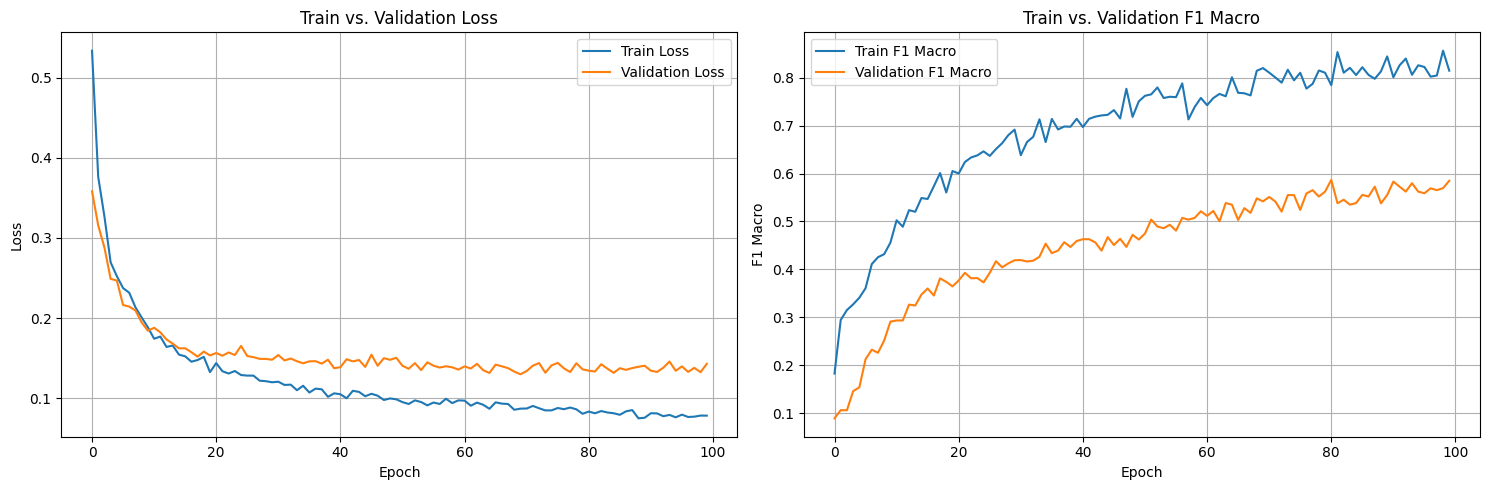

In [18]:
# Load the CSV file
metrics_df = pd.read_csv("/kaggle/working/logs/exp_20260204_215821/version_0/metrics.csv")
metrics_df_ = metrics_df.dropna(how='all') # Drop rows where all values are NaN
metrics_df_ = metrics_df_.ffill() # Forward-fill NaN values (carry last valid observation forward)
metrics_df_ = metrics_df_.groupby('epoch').last().reset_index()

# plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(metrics_df_["epoch"], metrics_df_["train_loss"], label="Train Loss")
axes[0].plot(metrics_df_["epoch"], metrics_df_["val_loss"], label="Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train vs. Validation Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(metrics_df_["epoch"], metrics_df_["train_f1_macro"], label="Train F1 Macro")
axes[1].plot(metrics_df_["epoch"], metrics_df_["val_f1_macro"], label="Validation F1 Macro")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1 Macro")
axes[1].set_title("Train vs. Validation F1 Macro")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Prediction

In [21]:
# prediction
path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle/evaluation'

test_dataset = S2Dataset(root_dir=path, bands=bands, class_idx=class_idx, labeled=False, transform=val_transform)

# sanity check
print(test_dataset.__len__())
img, img_id = test_dataset.__getitem__(0)
print(f"Shape: {img.shape}")

40
Shape: torch.Size([13, 224, 224])


In [19]:
checkpoint_dir = "/kaggle/working/checkpoints/moco_focal"
print(os.listdir(checkpoint_dir))

['last.ckpt', 'moco-epoch=080-val_f1_macro=0.5867.ckpt']


In [24]:
# Load the trained model
checkpoint_path = "/kaggle/working/checkpoints/moco_focal/moco-epoch=080-val_f1_macro=0.5867.ckpt"
model = MoCoClassifier.load_from_checkpoint(checkpoint_path)
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Define class names using your class_idx
class_names = {v: k for k, v in class_idx.items()}  # Reverse class_idx to map indices to names

# Create the test DataLoader
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4)

# predictions
image_ids = []
predictions = []

with torch.no_grad():
    for batch in test_loader:
        imgs, img_ids = batch  # img_ids are the folder names
        imgs = imgs.to("cuda" if torch.cuda.is_available() else "cpu")
        # Get model predictions
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        image_ids.extend(img_ids)
        predictions.extend(preds)

# Map predictions to class names
predicted_classes = [class_names[pred] for pred in predictions]

# Save to CSV
results_df = pd.DataFrame({
    "Id": image_ids,
    "Category": predicted_classes
})

results_df.to_csv("/kaggle/working/submission.csv", index=False)
results_df.head(5)

Loading official TorchGeo Sentinel-2 MoCo weights


,Id,Category
0,05835a9764364429b5ac3e11b052649d,Aphid
1,13739e32e7a84f669e6ef1284715e93b,Blast
2,1a419acc1ecc467897d5477a47353fa8,RPH
3,2fb5f497ae1b4b1eb7e8d7ced143aa46,Rust
4,310283f25b5f4b038114acbb6d61a357,Rust


save

In [23]:
import shutil

shutil.make_archive("/kaggle/working/checkpoints", 'zip', "/kaggle/working/checkpoints")
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'